In [1]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np


Bad key text.latex.preview in file /Users/thomasat/opt/miniconda3/envs/nhanes/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/thomasat/opt/miniconda3/envs/nhanes/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/thomasat/opt/miniconda3/envs/nhanes/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_

In [2]:
plt.rcParams['font.family'] = 'Helvetica'

In [3]:
loc = '../data/raw/gtrends/auc-6-18-24/'
files = os.listdir(loc)
release_date_file = loc + 'release-dates/Media list 6.15.24 - 2004-2024 - List for scatterplot.csv'
print(files)

['ghosts-in-our-machine.csv', '73-cows.csv', 'okja.csv', 'meat-the-truth.csv', 'vegucated.csv', '.DS_Store', 'speciesism.csv', 'the-smell-of-money.csv', 'the-end-of-animal-farming.csv', 'planeat.csv', 'the-end-of-medicine.csv', 'milked.csv', 'the-game-changers.csv', 'walking-with-peety.csv', 'eating-our-way-to-extinction.csv', 'dominion.csv', 'how-not-to-die.csv', 'china-study.csv', 'eating-animals.csv', 'a-sacred-duty.csv', 'cowspiracy.csv', 'peaceable-kingdom.csv', 'bleating-hearts.csv', 'you-are-what-you-eat.csv', 'earthlings.csv', 'why-we-love-dogs.csv', 'what-the-health.csv', 'eating-you-alive.csv', 'forks-over-knives.csv', 'release-dates']


In [4]:
media_data = pd.read_csv(release_date_file)[['Name', 'Release date', 'Advocacy angle', 'Content type']]
time_name = 'Release date'
media_data[time_name] = pd.to_datetime(media_data['Release date'], infer_datetime_format=True, errors='coerce')
release_dates_dict = dict(zip(media_data['Name'], media_data['Release date']))
release_dates_dict


{'The China Study': Timestamp('2005-01-01 00:00:00'),
 'Earthlings': Timestamp('2005-09-01 00:00:00'),
 'A Sacred Duty': Timestamp('2007-10-01 00:00:00'),
 'Meat the Truth': Timestamp('2007-12-01 00:00:00'),
 'Why We Love Dogs, Eat Pigs, and Wear Cows': Timestamp('2009-01-01 00:00:00'),
 'Peaceable Kingdom: The Journey Home': Timestamp('2009-09-01 00:00:00'),
 'Eating Animals': Timestamp('2009-11-01 00:00:00'),
 'PLANEAT': Timestamp('2010-04-01 00:00:00'),
 'Forks Over Knives': Timestamp('2011-05-01 00:00:00'),
 'Vegucated': Timestamp('2011-10-01 00:00:00'),
 'Speciesism: The Movie': Timestamp('2013-09-01 00:00:00'),
 'Bleating Hearts': Timestamp('2013-11-01 00:00:00'),
 'The Ghosts in Our Machine': Timestamp('2013-11-01 00:00:00'),
 'Cowspiracy: The Sustainability Secret': Timestamp('2014-06-01 00:00:00'),
 'How Not to Die': Timestamp('2015-12-01 00:00:00'),
 'What the Health': Timestamp('2017-03-01 00:00:00'),
 'Okja': Timestamp('2017-06-01 00:00:00'),
 'Walking with Peety: The Dog W

In [326]:
"""
Popularity metrics:
- Total search volume
- Peak search volume
- Total/Average search volume in the X months post release
- Total/Average search volume in the X months post peak
"""
def compute_popularity_metric(df, name, shorter_name, time_name, release_dates_dict, 
                              aggregation, slice_anchor_point=None, pre_interval=None, post_interval=None):
    assert aggregation in ['peak', 'total', 'average']
    assert slice_anchor_point in ['peak', 'release_date', None]
    assert pre_interval is None or pre_interval <= 0
    assert post_interval is None or post_interval >= 0

    # In all cases threshold by release date
    release_date_idx = df.loc[df[time_name] == release_dates_dict[shorter_name]].index[0]            
    df = df.iloc[release_date_idx:,:]    

    # Slice data frame
    if slice_anchor_point is not None:
        assert pre_interval is not None and post_interval is not None
        if slice_anchor_point == 'peak':
            peak_idx = df[name].argmax()
            df = df.iloc[peak_idx-pre_interval:peak_idx+post_interval,:]
        #elif slice_anchor_point == 'release_date':
        #    release_date_idx = df.loc[df[time_name] == release_dates_dict[shorter_name]].index[0]            
        #    df = df.iloc[release_date_idx-pre_interval:release_date_idx+post_interval,:]

    # Now aggregate
    if aggregation == 'peak':
        metric = df[name].max()
    elif aggregation == 'total':
        metric = df[name].sum()
    elif aggregation == 'average':
        metric = df[name].mean()
    
    return metric

In [327]:
shorter_name_map = {'"you are what you eat"': 'You Are What You Eat: A Twin Experiment'}

In [328]:
metrics_dct = {'Name': [], 'Peak': [], 'Total': [], 'Average': [], 
               'Peak_post_release': [],
                'Average_post_release': [],
               'Total_post_release': [],
               'Average_post_peak': [],
               'Total_post_peak': [],
               'Average_3_months_post_peak': [],
               'Total_3_months_post_peak': []}

df_dct = {}

for file in files:
    if file.endswith('.csv'):
        print(file)
        df = pd.read_csv(loc + file,header=1)
        name = df.columns[1]
        df = df.replace(to_replace='<1',value='0')
        df[name] = df[name].astype(int)  
        df['T'] = pd.to_datetime(df['Month'], infer_datetime_format=True, errors='coerce')
        shorter_name = name[:-17]
                
        if shorter_name in shorter_name_map:
            shorter_name = shorter_name_map[shorter_name]
        
        df_dct[shorter_name] = df
        
        print(shorter_name, df[name].sum(), release_dates_dict[shorter_name])
        peak_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'peak', slice_anchor_point=None, pre_interval=None, post_interval=None)
        avg_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'average', slice_anchor_point=None, pre_interval=None, post_interval=None)
        total_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'total', slice_anchor_point=None, pre_interval=None, post_interval=None)
        peak_post_release_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'peak', slice_anchor_point='release_date', pre_interval=0, post_interval=1000)
        avg_post_release_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'average', slice_anchor_point='release_date', pre_interval=0, post_interval=1000)
        total_post_release_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'total', slice_anchor_point='release_date', pre_interval=0, post_interval=1000)
        avg_post_peak_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'average', slice_anchor_point='peak', pre_interval=0, post_interval=1000)
        total_post_peak_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'total', slice_anchor_point='peak', pre_interval=0, post_interval=1000)
        avg_post_peak_3_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'average', slice_anchor_point='peak', pre_interval=0, post_interval=3)
        total_post_peak_3_sv = compute_popularity_metric(df, name, shorter_name, 'T', release_dates_dict, 
                              'total', slice_anchor_point='peak', pre_interval=0, post_interval=3)
        metrics_dct['Name'].append(shorter_name)
        metrics_dct['Peak'].append(peak_sv)
        metrics_dct['Average'].append(avg_sv)
        metrics_dct['Total'].append(total_sv)
        metrics_dct['Peak_post_release'].append(peak_post_release_sv)
        metrics_dct['Average_post_release'].append(avg_post_release_sv)
        metrics_dct['Total_post_release'].append(total_post_release_sv)
        metrics_dct['Average_post_peak'].append(avg_post_peak_sv)
        metrics_dct['Total_post_peak'].append(total_post_peak_sv)
        metrics_dct['Average_3_months_post_peak'].append(avg_post_peak_3_sv)
        metrics_dct['Total_3_months_post_peak'].append(total_post_peak_3_sv)

ghosts-in-our-machine.csv
The Ghosts in Our Machine 2 2013-11-01 00:00:00
73-cows.csv
73 Cows 0 2018-09-01 00:00:00
okja.csv
Okja 408 2017-06-01 00:00:00
meat-the-truth.csv
Meat the Truth 0 2007-12-01 00:00:00
vegucated.csv
Vegucated 41 2011-10-01 00:00:00
speciesism.csv
Speciesism: The Movie 0 2013-09-01 00:00:00
the-smell-of-money.csv
The Smell Of Money 1 2022-04-01 00:00:00
the-end-of-animal-farming.csv
The End of Animal Farming 2 2018-11-01 00:00:00
planeat.csv
PLANEAT 0 2010-04-01 00:00:00
the-end-of-medicine.csv
The End of Medicine 1 2022-06-01 00:00:00
milked.csv
MILKED 0 2021-11-01 00:00:00
the-game-changers.csv
The Game Changers 484 2018-01-01 00:00:00
walking-with-peety.csv
Walking with Peety: The Dog Who Saved My Life  in Sacramento 0 2017-10-01 00:00:00
eating-our-way-to-extinction.csv
Eating Our Way to Extinction 0 2021-10-01 00:00:00
dominion.csv
Dominion 31 2018-03-01 00:00:00
how-not-to-die.csv
How Not to Die 117 2015-12-01 00:00:00
china-study.csv
The China Study 471 2

In [329]:
df[name].argmax(), df[name].max(), df['T'][df[name].argmax()]

(92, 28, Timestamp('2011-09-01 00:00:00'))

In [330]:
metrics_df = pd.DataFrame(metrics_dct)
metrics_df

,Name,Peak,Total,Average,Peak_post_release,Average_post_release,Total_post_release,Average_post_peak,Total_post_peak,Average_3_months_post_peak,Total_3_months_post_peak
0,The Ghosts in Our Machine,1,1,0.007874,1,0.007874,1,0.007874,1,0.333333,1
1,73 Cows,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
2,Okja,100,391,4.654762,100,4.654762,391,4.240964,352,42.333333,127
3,Meat the Truth,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
4,Vegucated,3,41,0.269737,3,0.269737,41,0.218978,30,2.666667,8
5,Speciesism: The Movie,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
6,The Smell Of Money,1,1,0.038462,1,0.038462,1,0.166667,1,0.333333,1
7,The End of Animal Farming,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
8,PLANEAT,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
9,The End of Medicine,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0


In [331]:
tgc = df_dct['The Game Changers']

tgc_post_release = tgc.loc[tgc['T'] >= release_dates_dict['The Game Changers']]
tgc_post_release['The Game Changers: (United States)'].sum()

371

In [332]:
metrics_dct

{'Name': ['The Ghosts in Our Machine',
  '73 Cows',
  'Okja',
  'Meat the Truth',
  'Vegucated',
  'Speciesism: The Movie',
  'The Smell Of Money',
  'The End of Animal Farming',
  'PLANEAT',
  'The End of Medicine',
  'MILKED',
  'The Game Changers',
  'Walking with Peety: The Dog Who Saved My Life  in Sacramento',
  'Eating Our Way to Extinction',
  'Dominion',
  'How Not to Die',
  'The China Study',
  'Eating Animals',
  'A Sacred Duty',
  'Cowspiracy: The Sustainability Secret',
  'Peaceable Kingdom: The Journey Home',
  'Bleating Hearts',
  'You Are What You Eat: A Twin Experiment',
  'Earthlings',
  'Why We Love Dogs, Eat Pigs, and Wear Cows',
  'What the Health',
  'Eating You Alive',
  'Forks Over Knives'],
 'Peak': [1,
  0,
  100,
  0,
  3,
  0,
  1,
  0,
  0,
  0,
  0,
  47,
  0,
  0,
  1,
  3,
  5,
  6,
  0,
  12,
  0,
  0,
  29,
  4,
  0,
  84,
  4,
  28],
 'Total': [1,
  0,
  391,
  0,
  41,
  0,
  1,
  0,
  0,
  0,
  0,
  371,
  0,
  0,
  24,
  115,
  471,
  101,
  0,
  

In [333]:
media_data

,Name,Release date,Advocacy angle,Content type
0,The China Study,2005-01-01,Health,Book
1,Earthlings,2005-09-01,Animal Welfare,Film
2,A Sacred Duty,2007-10-01,Animal Welfare,Film
3,Meat the Truth,2007-12-01,Environment,Film
4,"Why We Love Dogs, Eat Pigs, and Wear Cows",2009-01-01,Animal Welfare,Book
5,Peaceable Kingdom: The Journey Home,2009-09-01,Animal Welfare,Film
6,Eating Animals,2009-11-01,Animal Welfare,Book
7,PLANEAT,2010-04-01,Health,Film
8,Forks Over Knives,2011-05-01,Health,Film
9,Vegucated,2011-10-01,Animal Welfare,Film


In [334]:
metrics_df.columns

Index(['Name', 'Peak', 'Total', 'Average', 'Peak_post_release',
       'Average_post_release', 'Total_post_release', 'Average_post_peak',
       'Total_post_peak', 'Average_3_months_post_peak',
       'Total_3_months_post_peak'],
      dtype='object')

In [335]:
df = media_data.merge(metrics_df, on='Name', how='inner')
df

,Name,Release date,Advocacy angle,Content type,Peak,Total,Average,Peak_post_release,Average_post_release,Total_post_release,Average_post_peak,Total_post_peak,Average_3_months_post_peak,Total_3_months_post_peak
0,The China Study,2005-01-01,Health,Book,5,471,2.021459,5,2.021459,471,1.869565,301,4.333333,13
1,Earthlings,2005-09-01,Animal Welfare,Film,4,241,1.071111,4,1.071111,241,0.807339,88,2.333333,7
2,A Sacred Duty,2007-10-01,Animal Welfare,Film,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
3,Meat the Truth,2007-12-01,Environment,Film,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
4,"Why We Love Dogs, Eat Pigs, and Wear Cows",2009-01-01,Animal Welfare,Book,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
5,Peaceable Kingdom: The Journey Home,2009-09-01,Animal Welfare,Film,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
6,Eating Animals,2009-11-01,Animal Welfare,Book,6,101,0.577143,6,0.577143,101,0.577143,101,4.000000,12
7,PLANEAT,2010-04-01,Health,Film,0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
8,Forks Over Knives,2011-05-01,Health,Film,28,1107,7.050955,28,7.050955,1107,6.908497,1057,21.333333,64
9,Vegucated,2011-10-01,Animal Welfare,Film,3,41,0.269737,3,0.269737,41,0.218978,30,2.666667,8


In [336]:
df = df.loc[df['Name'] != 'Seaspiracy']

In [337]:
# Create merged dataframe: Name | Release date | Advocacy angle | Media type | Metrics
date = df['Release date'][0]
date - timedelta(days=5)

Timestamp('2004-12-27 00:00:00')

In [338]:
df['Name'][3]

'Meat the Truth'

In [339]:
abbrev_title_dct = {'I Am an Animal: The Story of Ingrid Newkirk and PETA': 'I Am an Animal',
                  # 'The Ghosts in Our Machine': 'Ghosts in Our Machine',
                   'Cowspiracy: The Sustainability Secret': 'Cowspiracy',
                   'You Are What You Eat: A Twin Experiment': 'You Are What You Eat',
                   'The Smell Of Money': 'The Smell of Money'}

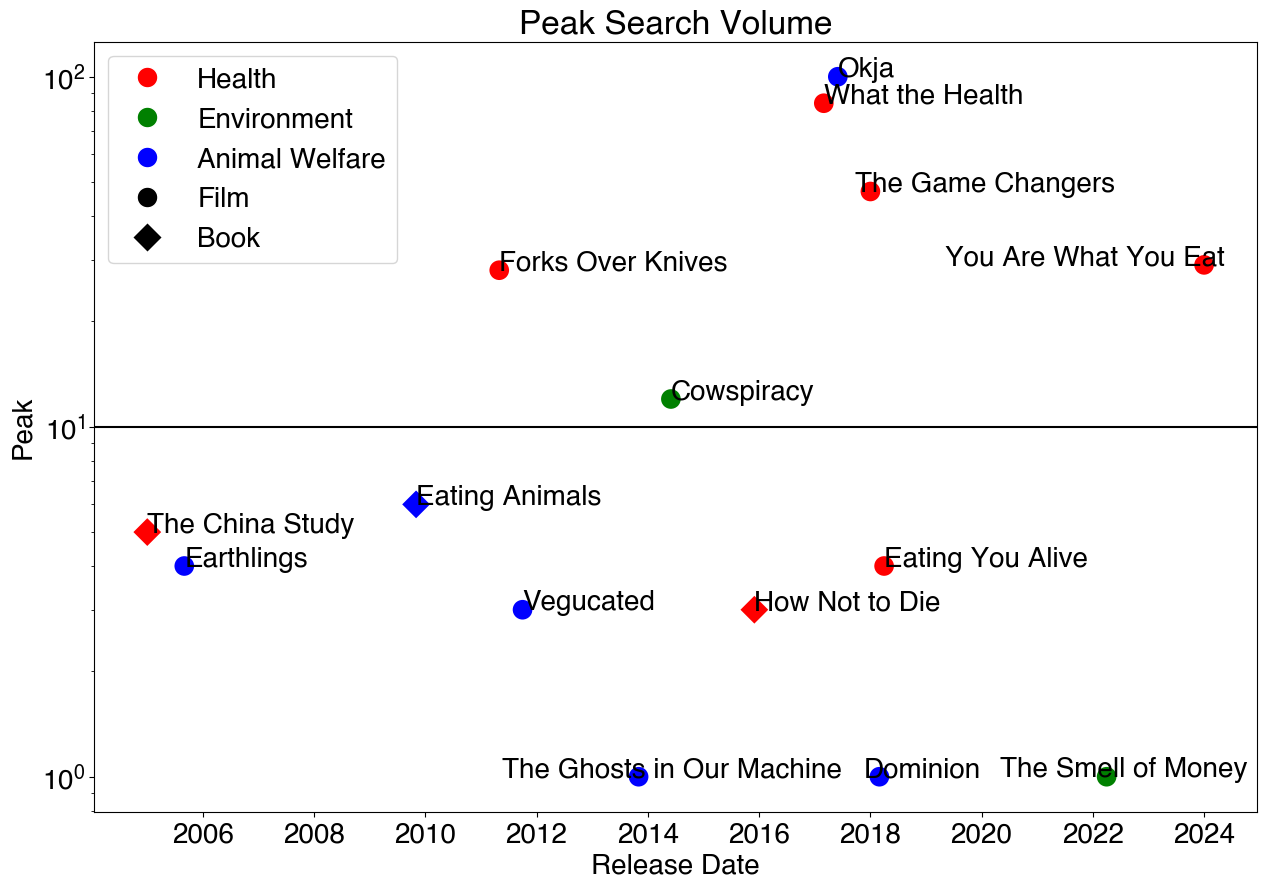

In [340]:
# Now create figures
# Plot
#plt.figure(figsize=(15,5))
metrics = ['Peak', 'Total', 'Average', 'Peak_post_release',
       'Average_post_release', 'Total_post_release', 'Average_post_peak',
       'Total_post_peak', 'Average_3_months_post_peak',
       'Total_3_months_post_peak']

plt.rcParams.update({'font.size': 20})

for popularity_metric in ['Peak']:
    plt.figure(figsize=(15,10))
    time_name = 'T'
    date_col = 'Date'
    month_interval=12
    color_map = {'Health': 'red', 'Environment': 'green', 'Animal Welfare': 'blue'}
    marker_map = {'Book': 'D', 'Film': 'o'}
    df[time_name] = pd.to_datetime(df['Release date'], infer_datetime_format=True, errors='coerce')
    df = df.sort_values(time_name).reset_index(drop='True')
    
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=month_interval))

    for i in range(df.shape[0]):
        this_time_annot = df[time_name][i]
        if df['Name'][i] == 'You Are What You Eat: A Twin Experiment':
            this_time_annot = df[time_name][i] - timedelta(days=1700)
        elif df['Name'][i] == 'The Smell Of Money':
            this_time_annot = df[time_name][i] - timedelta(days=700)   
        elif df['Name'][i] == 'The Game Changers':
            this_time_annot = df[time_name][i] - timedelta(days=100)
        elif df['Name'][i] == 'The Ghosts in Our Machine':
            this_time_annot = df[time_name][i] - timedelta(days=900)  
        elif df['Name'][i] == 'Dominion':
            this_time_annot = df[time_name][i] - timedelta(days=100) 
        plt.scatter(df[time_name][i], df[popularity_metric][i],s=200, 
                    color=color_map[df['Advocacy angle'][i]], marker=marker_map[df['Content type'][i]],alpha=1.0,
                   edgecolors='none')  
        if df[popularity_metric][i] != 0:
            if df['Name'][i] in abbrev_title_dct:
                plt.annotate(abbrev_title_dct[df['Name'][i]], (this_time_annot, df[popularity_metric][i]))
            else:
                plt.annotate(df['Name'][i], (this_time_annot, df[popularity_metric][i]))            

    # Adding legend
    legend_labels_color = {'Health': 'Health', 'Environment': 'Environment', 'Animal Welfare': 'Animal Welfare'}
    legend_labels_marker = {'Book': 'Book', 'Film': 'Film'}
    legend_handles = []
    for label in legend_labels_color:
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_labels_color[label],
                                         markerfacecolor=color_map.get(label, 'black'),
                                         markersize=15, alpha=1.0))
    legend_handles.append(plt.Line2D([0], [0], marker=marker_map['Film'], color='w', label='Film',
                                         markerfacecolor='black',
                                         markersize=15, alpha=1.0))
    legend_handles.append(plt.Line2D([0], [0], marker=marker_map['Book'], color='w', label='Book',
                                         markerfacecolor='black',
                                         markersize=15, alpha=1.0))

    plt.legend(handles=legend_handles, loc='upper left')

    #plt.gcf().autofmt_xdate()    
    plt.ylabel(popularity_metric)
    plt.title('Peak Search Volume')
    plt.xlabel('Release Date')
    plt.yscale('log')
    plt.axhline(10, color='black')
    plt.show()

Peak


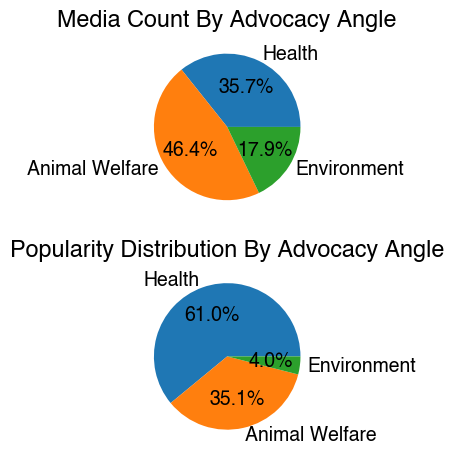

In [343]:
# Pie chart
plt.rcParams.update({'font.size': 14})
for metric in ['Peak']:#metrics:
    labels = []
    pop_sizes = []
    sizes = []
    
    tot_pop = df[metric].sum()
    tot = df.shape[0]

    for angle in df['Advocacy angle'].unique():
        subdf = df.loc[df['Advocacy angle'] == angle]
        subdf_tot = subdf.shape[0]
        subdf_tot_pop = subdf[metric].sum()
        labels.append(angle)
        pop_sizes.append(subdf_tot_pop/tot_pop)
        sizes.append(subdf_tot/tot)
        
        
    # Now a pie chart
    print(metric)
    fig, axs = plt.subplots(2,1)
    axs[0].pie(sizes, labels=labels, autopct='%1.1f%%')
    axs[0].set_title('Media Count By Advocacy Angle')

    axs[1].pie(pop_sizes, labels=labels, autopct='%1.1f%%')
    axs[1].set_title('Popularity Distribution By Advocacy Angle')
    fig.tight_layout()
    plt.show()
    plt.close('all')

Peak


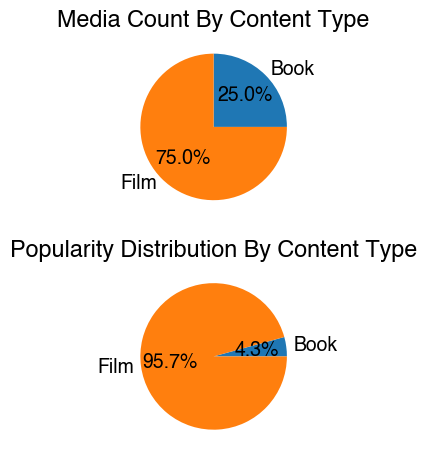

In [344]:
for metric in ['Peak']:#metrics:
    labels = []
    pop_sizes = []
    sizes = []
    
    tot_pop = df[metric].sum()
    tot = df.shape[0]

    for angle in df['Content type'].unique():
        subdf = df.loc[df['Content type'] == angle]
        subdf_tot = subdf.shape[0]
        subdf_tot_pop = subdf[metric].sum()
        labels.append(angle)
        pop_sizes.append(subdf_tot_pop/tot_pop)
        sizes.append(subdf_tot/tot)
        
        
    # Now a pie chart
    print(metric)
    fig, axs = plt.subplots(2,1)
    axs[0].pie(sizes, labels=labels, autopct='%1.1f%%')
    axs[0].set_title('Media Count By Content Type')

    axs[1].pie(pop_sizes, labels=labels, autopct='%1.1f%%')
    axs[1].set_title('Popularity Distribution By Content Type')
    fig.tight_layout()
    plt.show()
    plt.close('all')

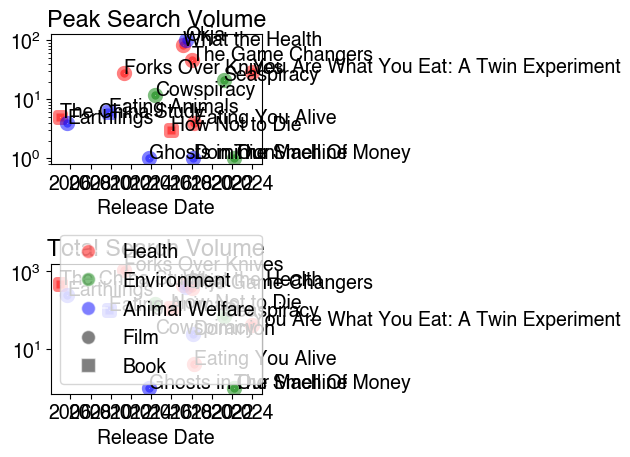

In [107]:
# Create the figures for paper
plt.rcParams['font.family'] = 'Helvetica'
fig, axs = plt.subplots(2,1)
time_name = 'T'
date_col = 'Date'
month_interval=12
color_map = {'Health': 'red', 'Environment': 'green', 'Animal Welfare': 'blue'}
marker_map = {'Book': 's', 'Film': 'o'}
df[time_name] = pd.to_datetime(df['Release date'], infer_datetime_format=True, errors='coerce')
df = df.sort_values(time_name).reset_index(drop='True')

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=month_interval))

#Axis 1
first_pop_metric = 'Peak_post_release'
second_pop_metric = 'Total_post_release'

for i in range(df.shape[0]):
    axs[0].scatter(df[time_name][i], df[first_pop_metric][i],linewidth=5, 
                color=color_map[df['Advocacy angle'][i]], marker=marker_map[df['Content type'][i]],alpha=0.5)  
    if df[popularity_metric][i] != 0:
        if df['Name'][i] in abbrev_title_dct:
            axs[0].annotate(abbrev_title_dct[df['Name'][i]], (df[time_name][i], df[first_pop_metric][i]))
        else:
            axs[0].annotate(df['Name'][i], (df[time_name][i], df[first_pop_metric][i]))            

# Adding legend
legend_labels_color = {'Health': 'Health', 'Environment': 'Environment', 'Animal Welfare': 'Animal Welfare'}
legend_labels_marker = {'Book': 'Book', 'Film': 'Film'}
legend_handles = []
for label in legend_labels_color:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_labels_color[label],
                                     markerfacecolor=color_map.get(label, 'black'),
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Film',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', label='Book',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))

#axs[0].legend(handles=legend_handles)

#plt.gcf().autofmt_xdate()    
axs[0].set_title('Peak Search Volume')
axs[0].set_xlabel('Release Date')
axs[0].set_yscale('log')
#plt.axhline(10, color='black')

for i in range(df.shape[0]):
    axs[1].scatter(df[time_name][i], df[second_pop_metric][i],linewidth=5, 
                color=color_map[df['Advocacy angle'][i]], marker=marker_map[df['Content type'][i]],alpha=0.5)  
    if df[popularity_metric][i] != 0:
        if df['Name'][i] in abbrev_title_dct:
            axs[1].annotate(abbrev_title_dct[df['Name'][i]], (df[time_name][i], df[popularity_metric][i]))
        else:
            axs[1].annotate(df['Name'][i], (df[time_name][i], df[second_pop_metric][i]))            

# Adding legend
legend_labels_color = {'Health': 'Health', 'Environment': 'Environment', 'Animal Welfare': 'Animal Welfare'}
legend_labels_marker = {'Book': 'Book', 'Film': 'Film'}
legend_handles = []
for label in legend_labels_color:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_labels_color[label],
                                     markerfacecolor=color_map.get(label, 'black'),
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Film',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', label='Book',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))

axs[1].legend(handles=legend_handles)

#plt.gcf().autofmt_xdate()    
axs[1].set_title('Total Search Volume')
axs[1].set_xlabel('Release Date')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

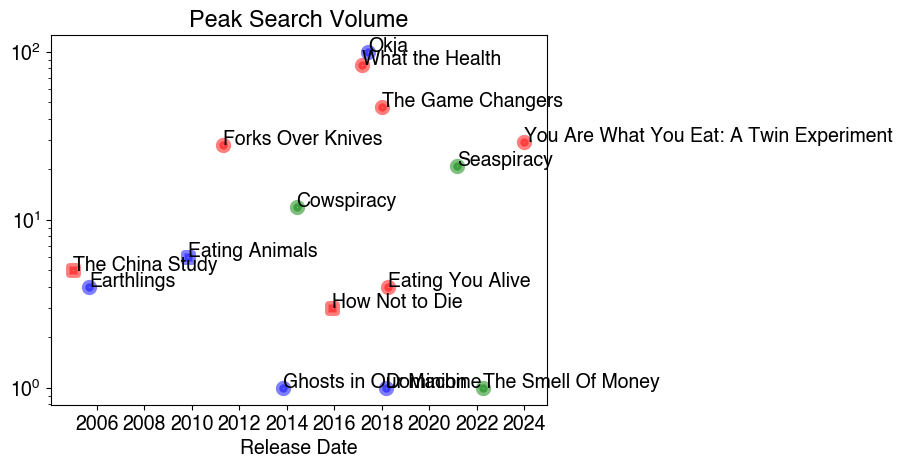

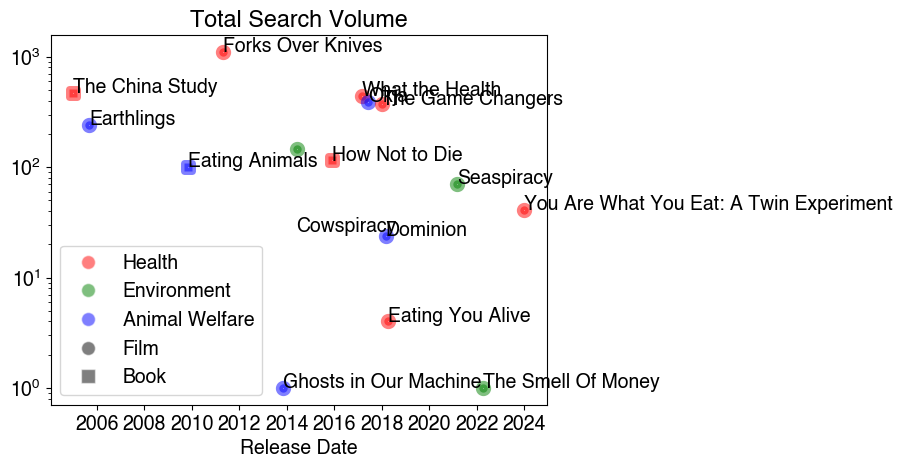

In [108]:
time_name = 'T'
date_col = 'Date'
month_interval=12
color_map = {'Health': 'red', 'Environment': 'green', 'Animal Welfare': 'blue'}
marker_map = {'Book': 's', 'Film': 'o'}
df[time_name] = pd.to_datetime(df['Release date'], infer_datetime_format=True, errors='coerce')
df = df.sort_values(time_name).reset_index(drop='True')

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=month_interval))

#Axis 1
first_pop_metric = 'Peak_post_release'
second_pop_metric = 'Total_post_release'

for i in range(df.shape[0]):
    plt.scatter(df[time_name][i], df[first_pop_metric][i],linewidth=5, 
                color=color_map[df['Advocacy angle'][i]], marker=marker_map[df['Content type'][i]],alpha=0.5)  
    if df[popularity_metric][i] != 0:
        if df['Name'][i] in abbrev_title_dct:
            plt.annotate(abbrev_title_dct[df['Name'][i]], (df[time_name][i], df[first_pop_metric][i]))
        else:
            plt.annotate(df['Name'][i], (df[time_name][i], df[first_pop_metric][i]))            

# Adding legend
legend_labels_color = {'Health': 'Health', 'Environment': 'Environment', 'Animal Welfare': 'Animal Welfare'}
legend_labels_marker = {'Book': 'Book', 'Film': 'Film'}
legend_handles = []
for label in legend_labels_color:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_labels_color[label],
                                     markerfacecolor=color_map.get(label, 'black'),
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Film',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', label='Book',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))

#axs[0].legend(handles=legend_handles)

#plt.gcf().autofmt_xdate()    
plt.title('Peak Search Volume')
plt.xlabel('Release Date')
plt.yscale('log')
#plt.axhline(10, color='black')

plt.show()

for i in range(df.shape[0]):
    plt.scatter(df[time_name][i], df[second_pop_metric][i],linewidth=5, 
                color=color_map[df['Advocacy angle'][i]], marker=marker_map[df['Content type'][i]],alpha=0.5)  
    if df[popularity_metric][i] != 0:
        if df['Name'][i] in abbrev_title_dct:
            plt.annotate(abbrev_title_dct[df['Name'][i]], (df[time_name][i], df[popularity_metric][i]))
        else:
            plt.annotate(df['Name'][i], (df[time_name][i], df[second_pop_metric][i]))            

# Adding legend
legend_labels_color = {'Health': 'Health', 'Environment': 'Environment', 'Animal Welfare': 'Animal Welfare'}
legend_labels_marker = {'Book': 'Book', 'Film': 'Film'}
legend_handles = []
for label in legend_labels_color:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_labels_color[label],
                                     markerfacecolor=color_map.get(label, 'black'),
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Film',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))
legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', label='Book',
                                     markerfacecolor='black',
                                     markersize=10, alpha=0.5))

plt.legend(handles=legend_handles)

#plt.gcf().autofmt_xdate()    
plt.title('Total Search Volume')
plt.xlabel('Release Date')
plt.yscale('log')

#plt.tight_layout()
plt.show()

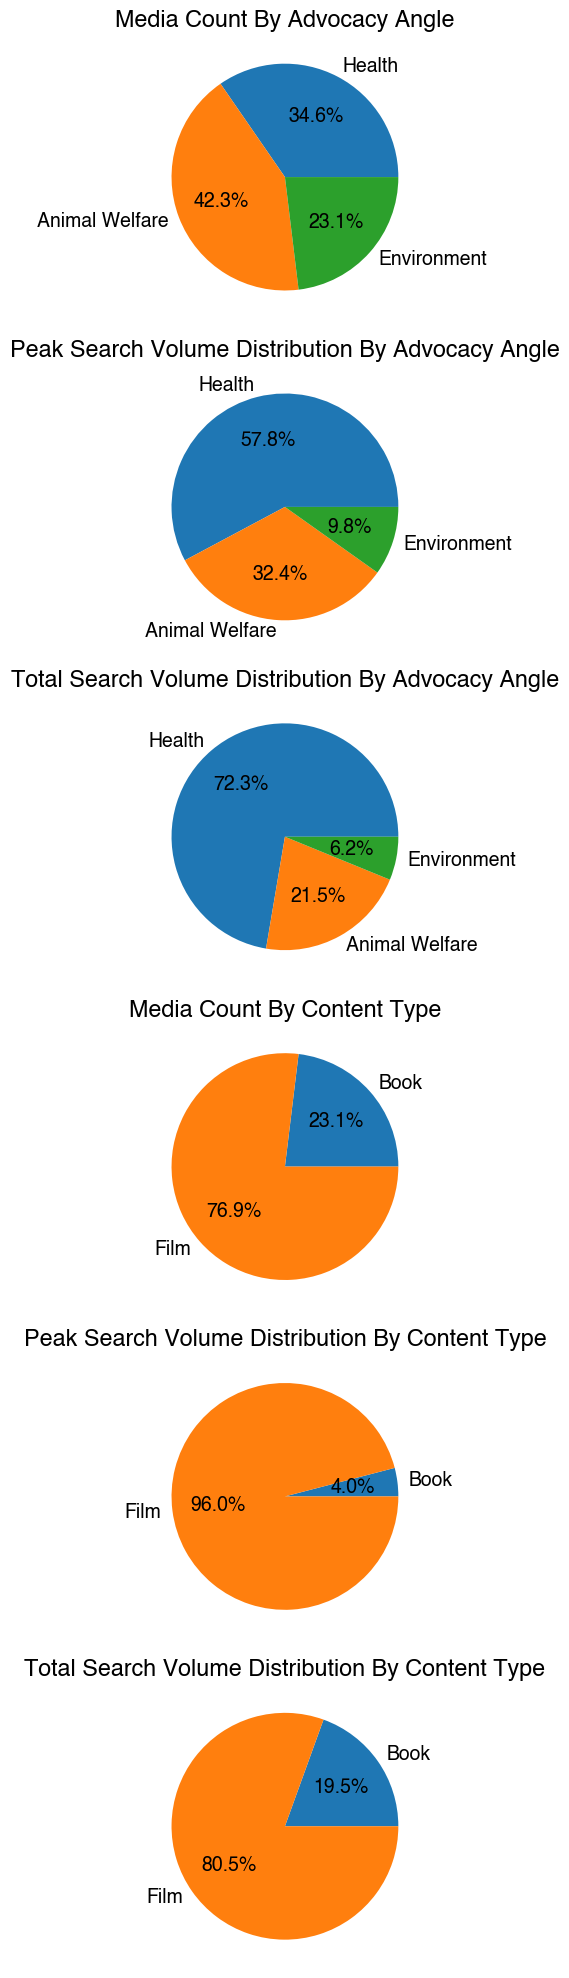

In [109]:
# Pie charts
labels = []
pop_sizes = []
sizes = []

tot = df.shape[0]

metrics = ['Peak_post_release', 'Total_post_release']
name_map = {'Peak_post_release': 'Peak Search Volume', 'Total_post_release': 'Total Search Volume'}

cat = 'Advocacy angle'

for angle in df[cat].unique():
    subdf = df.loc[df[cat] == angle]
    subdf_tot = subdf.shape[0]
    sizes.append(subdf_tot/tot)
    labels.append(angle)

fig, axs = plt.subplots(6,1, figsize=(40,20))
axs[0].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[0].set_title('Media Count By Advocacy Angle')   

i = 1

for metric in metrics:
    tot_pop = df[metric].sum()
    pop_sizes = []
    
    for angle in df[cat].unique(): 
        subdf = df.loc[df[cat] == angle]
        subdf_tot_pop = subdf[metric].sum()
        pop_sizes.append(subdf_tot_pop/tot_pop)

    axs[i].pie(pop_sizes, labels=labels, autopct='%1.1f%%')
    axs[i].set_title('{d} Distribution By Advocacy Angle'.format(d = name_map[metric]))
    
    i+=1 


labels = []
pop_sizes = []
sizes = []

tot = df.shape[0]

metrics = ['Peak_post_release', 'Total_post_release']
name_map = {'Peak_post_release': 'Peak Search Volume', 'Total_post_release': 'Total Search Volume'}

for angle in df['Content type'].unique():
    subdf = df.loc[df['Content type'] == angle]
    subdf_tot = subdf.shape[0]
    sizes.append(subdf_tot/tot)
    labels.append(angle)

#fig, axs = plt.subplots(1 + len(metrics),1)
axs[3].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[3].set_title('Media Count By Content Type')   

i = 4

for metric in metrics:
    tot_pop = df[metric].sum()
    pop_sizes = []
    
    for angle in df['Content type'].unique(): 
        subdf = df.loc[df['Content type'] == angle]
        subdf_tot_pop = subdf[metric].sum()
        pop_sizes.append(subdf_tot_pop/tot_pop)

    axs[i].pie(pop_sizes, labels=labels, autopct='%1.1f%%')
    axs[i].set_title('{d} Distribution By Content Type'.format(d = name_map[metric]))
    
    i+=1 
    
    
fig.tight_layout()
#plt.show()
#plt.close('all')

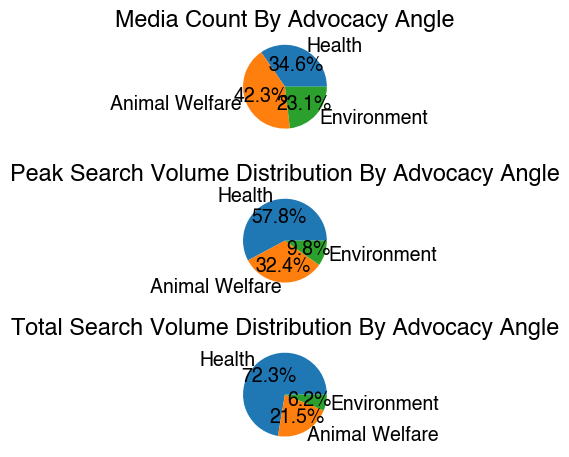

In [110]:
labels = []
pop_sizes = []
sizes = []

tot = df.shape[0]

metrics = ['Peak_post_release', 'Total_post_release']
name_map = {'Peak_post_release': 'Peak Search Volume', 'Total_post_release': 'Total Search Volume'}

cat = 'Advocacy angle'

for angle in df[cat].unique():
    subdf = df.loc[df[cat] == angle]
    subdf_tot = subdf.shape[0]
    sizes.append(subdf_tot/tot)
    labels.append(angle)

fig, axs = plt.subplots(1 + len(metrics),1)
axs[0].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[0].set_title('Media Count By Advocacy Angle')   

i = 1

for metric in metrics:
    tot_pop = df[metric].sum()
    pop_sizes = []
    
    for angle in df[cat].unique(): 
        subdf = df.loc[df[cat] == angle]
        subdf_tot_pop = subdf[metric].sum()
        pop_sizes.append(subdf_tot_pop/tot_pop)

    axs[i].pie(pop_sizes, labels=labels, autopct='%1.1f%%')
    axs[i].set_title('{d} Distribution By Advocacy Angle'.format(d = name_map[metric]))
    
    i+=1 
    
fig.tight_layout()
plt.show()
plt.close('all')